# FASTAI intro

In [3]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [4]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [5]:
df = pd.DataFrame({'label':dataset.target,
                   'text':dataset.data})


In [6]:
df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

In [8]:
df.head()

,label,text
0,10,"Well, I will have to change the scoring on my ..."
1,1,Archive-name: graphics/resources-list/part1\nL...
2,10,"\nAnd of course, Mike Ramsey was (at one time)..."
3,10,"As I promised, I would give you the name of th..."
4,10,GAME(S) OF 4/15\n---------------\nADIRONDACK 6...


# Enter FAST.AI

In [34]:
data_lm = (TextList.from_df(df, cols='text')
                .split_by_rand_pct()
                .label_for_lm()
                #.label_from_df(cols='label')
                .databunch(bs=32))

In [35]:
data_lm.x[:1]

LMTextList (1 items)
xxbos xxmaj well , i will have to change the scoring on my playoff pool . xxmaj unfortunately 
  i do n't have time right now , but i will certainly post the new scoring 
  rules by tomorrow . xxmaj does it matter ? xxmaj no , you 'll enter anyway ! ! ! xxmaj good ! 
 
  -- 
  xxmaj keith xxmaj keller 				 xxup let xxup 's xxup go xxup rangers xxrep 5 ! 
 						 xxup let xxup 's xxup go xxup quakers xxrep 5 ! 
 	 kkeller@mail.sas.upenn.edu 		 xxup ivy xxup league xxup champs xxrep 4 !
Path: .

In [36]:
data_lm.y

LMLabelList (948 items)
,,,,
Path: .

In [37]:
data_lm.show_batch()

idx,text
0,xxup go xxup rangers xxrep 5 ! \n \t\t\t\t\t\t xxup let xxup 's xxup go xxup quakers xxrep 5 ! \n \t kkeller@mail.sas.upenn.edu \t\t xxup ivy xxup league xxup champs xxrep 4 ! xxbos xxmaj archive - name : graphics / resources - list / xxunk \n xxmaj last - modified : 1993 / 04 / 17 \n \n \n xxmaj computer xxmaj graphics xxmaj resource xxmaj listing
1,bourke < pdbourke@ccu1.aukland.ac.nz > \n \n xxunk [ xxunk ] : xxunk / xxup sgi / xxmaj facial - xxmaj animation - xxmaj steve xxmaj xxunk \n \t site for facial animation . \n \t xxmaj steve xxmaj xxunk < xxunk xxup or xxunk > \n \n \n 4 . xxmaj mail servers and graphics - oriented bbses \n xxrep 43 = \n \n xxmaj please
2,"meet in a point ( p , say ) which is the centre of this circle . \n xxmaj this circle must lie on the surface of the desired sphere . \n \n xxmaj consider the normal to the plane xxup abc passing through xxup p. xxmaj all points \n on this normal are xxunk from a , b and c and its circle ( in \n"
3,"time had xxunk . \n \n ` ` i 'm glad i did n't see it go in at the end , "" xxmaj blues coach xxmaj bob xxmaj berry said . \n \n xxmaj if the goal had xxunk , he 'd have been more upset than he was by the xxmaj blues ' \n xxunk in the final 24 minutes . xxmaj holding on for"
4,"go xxunk , kill all on ice , but xxmaj pit wins ) \n \t xxmaj chi vs. xxmaj tor - xxmaj tor in 7 ( xxmaj tor defense finally get it together ) \n \t xxmaj cal vs. xxmaj win - xxmaj cal in 6 ( xxmaj win too xxunk after 1st series ) \n \n xxmaj conference finals \n \t xxmaj pit vs. xxmaj bos - xxmaj"


In [38]:
data_lm.vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             '\n ': 9,
             ',': 10,
             '.': 11,
             'the': 12,
             '-': 13,
             '\n \n ': 14,
             ')': 15,
             'to': 16,
             '(': 17,
             '\t': 18,
             'a': 19,
             'and': 20,
             'of': 21,
             ':': 22,
             'in': 23,
             'i': 24,
             'is': 25,
             'for': 26,
             '1': 27,
             'it': 28,
             '/': 29,
             'that': 30,
             '0': 31,
             'on': 32,
             '2': 33,
             'you': 34,
             '4': 35,
             '"': 36,
             "'s": 37,
             'be': 38,
             '!': 39,
             'this': 40,
             'with': 41,


In [7]:
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

NameError: name 'df_trn' is not defined

# Model

In [48]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


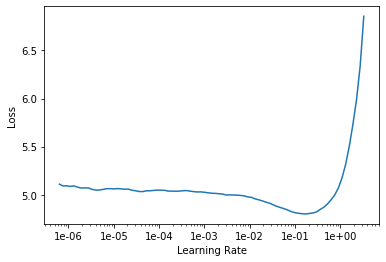

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.223894,3.640579,0.305446,00:11
1,3.564629,3.407223,0.332649,00:11
2,3.102586,3.327701,0.341161,00:11
3,2.828783,3.308429,0.346488,00:11


In [52]:
TEXT = "The coach said"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The coach said that Techniques School would be a middle school for people who would n't be able to direct to the above system and would be able to learn harder their self - use . The CBC reported
The coach said that the team would like to 
  go to the World Championships . The NHL 's teams would send their requests to players from the NHL . It would be the team that


In [53]:
learn.save('pretrained')

In [54]:
learn.unfreeze(); 
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.716115,3.277621,0.350684,00:15
1,2.567410,3.256793,0.363363,00:15
2,2.226464,3.272996,0.363601,00:15
3,1.866192,3.336351,0.367113,00:15
4,1.619569,3.387283,0.364048,00:15


In [55]:
learn.save('fine_tuned')

In [56]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.571302,3.438952,0.359821,00:15
1,1.685357,3.477120,0.356592,00:15
2,1.403097,3.597580,0.352872,00:15
3,1.111390,3.698282,0.351994,00:15
4,0.932862,3.753394,0.351116,00:15


In [59]:
learn.load('fine_tuned');

In [60]:
TEXT = "The coach said"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The coach said it will be a LA Kings game for the next two 
  years . The team might have a coach and a coach . 
  The coach will be Coach , and once the coach
The coach said the Leafs ' captain is Bill Wirtz , and is 
  responsible for the Leafs ' 
  victory . When they were traded to Chicago , they were called " The Leafs


In [61]:
learn.save_encoder('fine_tuned_enc')

# Your turn

In [79]:
data_classification = (TextList.from_df(df, cols='text', vocab=data_lm.vocab)
                .split_by_rand_pct()
                .label_from_df(cols='label')
                .databunch(bs=32))

In [80]:
len(data_lm.vocab.itos)

6080

In [81]:
len(data_classification.vocab.itos)

6080

In [83]:
learn = text_classifier_learner(data_classification, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc');

In [86]:
data_classification.show_batch(10)

text,target
xxbos xxmaj archive - name : hockey - faq \n \n rec.sport.hockey answers to xxmaj frequently xxmaj asked xxmaj questions and other news : \n \n xxmaj contents : \n \n 0 . xxmaj new xxmaj info . \n 1 . xxup nhl \n 2 . xxup nhl xxmaj minor xxmaj leagues \n 3 . xxmaj college xxmaj hockey ( xxmaj north xxmaj america,10
xxbos xxmaj archive - name : graphics / resources - list / xxunk \n xxmaj last - modified : 1993 / 04 / 17 \n \n \n xxmaj computer xxmaj graphics xxmaj resource xxmaj listing : xxup weekly xxup posting [ xxup part 1 / 3 ] \n xxrep 51 = \n xxmaj last xxmaj change : 17 xxmaj april 1993 \n \n xxmaj many,1
xxbos xxmaj archive - name : graphics / resources - list / xxunk \n xxmaj last - modified : 1993 / 04 / 17 \n \n \n xxmaj computer xxmaj graphics xxmaj resource xxmaj listing : xxup weekly xxup posting [ xxup part 3 / 3 ] \n xxrep 51 = \n xxmaj last xxmaj change : 17 xxmaj april 1993 \n \n \n 11,1
xxbos xxmaj archive - name : jpeg - faq \n xxmaj last - modified : 18 xxmaj april 1993 \n \n xxmaj this xxup faq article xxunk xxup jpeg image compression . xxmaj suggestions for \n additions and xxunk are welcome . \n \n xxmaj new since version of 3 xxmaj april 1993 : \n * xxmaj new versions of xxmaj image xxmaj xxunk and,1
xxbos xxmaj archive - name : graphics / resources - list / xxunk \n xxmaj last - modified : 1993 / 04 / 17 \n \n \n xxmaj computer xxmaj graphics xxmaj resource xxmaj listing : xxup weekly xxup posting [ xxup part 2 / 3 ] \n xxrep 51 = \n xxmaj last xxmaj change : 17 xxmaj april 1993 \n \n \n 14,1
"xxbos xxmaj here are the standings after the xxmaj april 6 update . i 'll be leaving for xxmaj japan \n in 1.5 hours , and i wo n't be back until xxmaj april 17 . xxmaj xxunk , i will not \n post the week 27 results until xxmaj april 18 . xxmaj email sent between xxmaj april 13 and \n xxmaj april 18 will be",10
"xxbos xxmaj well , i 'm back from xxmaj xxunk , so here are the standings after the xxmaj april 13 update . \n \n \t - xxmaj andrew \n \n xxup usenet xxmaj hockey xxmaj draft xxmaj standings \n xxmaj week 27 \n \n xxmaj posn \t xxmaj team \t\t\t\t xxmaj pts \t xxmaj xxunk \t xxmaj xxunk \t xxmaj last xxmaj posn \n \n",10
"xxbos xxmaj here are the final stats for the xxup chl for the 1992 - 1993 season . \n \n xxmaj central xxmaj hockey xxmaj league \n \n xxunk xxup s. xxmaj memorial xxmaj drive \n xxmaj suite 205 \n xxmaj tulsa , xxup ok xxunk \n xxmaj phone : ( 918 ) xxunk - xxunk \n xxmaj fax : ( 918 ) xxunk",10
"xxbos xxmaj tampa xxmaj bay 1 1 0 - -2 \n xxmaj philadelphia 3 2 1 - -6 \n xxmaj first period \n 1 , xxmaj philadelphia , xxmaj carkner 3 ( unassisted ) 1:24 . \n 2 , xxmaj philadelphia , xxmaj hawgood 9 ( xxmaj recchi , xxmaj lindros ) pp , xxunk . \n 3 , xxmaj philadelphia , xxmaj lindros 37",10
"xxbos 1992 - 93 xxmaj los xxmaj angeles xxmaj kings xxmaj schedule / xxmaj results \n \n xxup tv : \n --- \n 2 preseason games , 82 of 84 regular season and all playoffs on xxup tv . \n \n ( xxup xxunk xxmaj prime xxmaj ticket , ( 5 ) = xxup xxunk xxmaj channel 5 , ( 7 ) = xxup abc xxmaj",10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


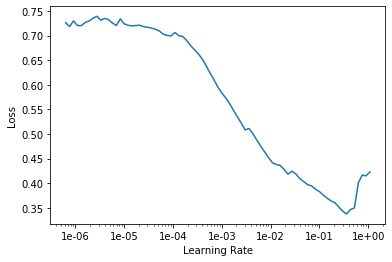

In [87]:
learn.lr_find();
learn.recorder.plot()

In [88]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.266938,0.169815,0.940678,00:19


In [89]:
learn.predict('the coach')

(Category 10, tensor(1), tensor([0.1096, 0.8904]))

In [97]:
learn.predict('it renders a beautiful twzfnkz')

(Category 1, tensor(0), tensor([0.9301, 0.0699]))